In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load, split, and scale the data

In [2]:
data = pd.read_csv( "Train_SU63ISt.csv", index_col = 0 )

In [3]:
data["hour"] = data.index

In [4]:
trainData = data[ : int(len(data) * 0.8) ]
testData = data[ int(len(data) * 0.8) : ] #When evaluating the model need to add the last inputSize from train data.

trainMax = np.max( trainData.Count )
trainMin = np.min( trainData.Count )

trainData.Count = ( trainData.Count.values - trainMin ) / (trainMax - trainMin)
testData.Count = ( testData.Count.values - trainMin ) / (trainMax - trainMin)
data.Count = ( data.Count.values - trainMin ) / (trainMax - trainMin)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Visualize the training/test data (scaled relative to training set)

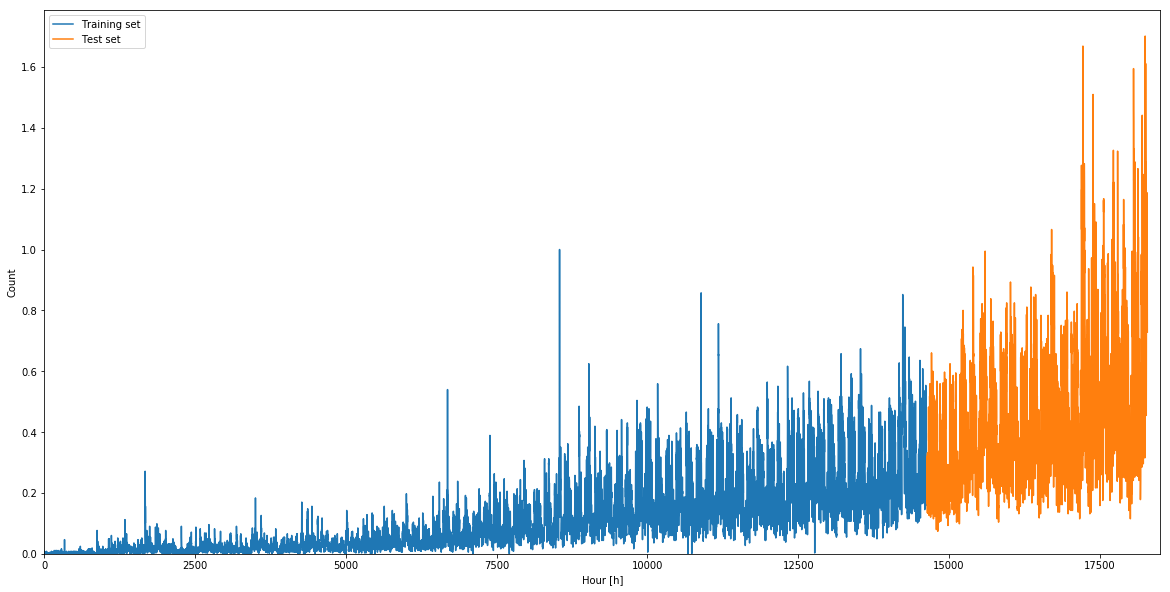

In [5]:
plt.figure( figsize =  ( 20, 10 ) )
plt.plot( trainData.hour, trainData.Count, label = "Training set" )
plt.plot( testData.hour, testData.Count, label = "Test set" )
plt.legend( loc = "best" )
plt.xlabel("Hour [h]")
plt.ylabel("Count")
plt.xlim(xmin = 0, xmax = 18500 )
plt.ylim( ymin = 0 )
plt.show()

## Define some useful functions

In [6]:
def genTimeSlices( data, time ):
    
    X = []
    
    for start in range(0, len(data) - time + 1 ):
        
        X.append( data[start: start + time] )
        
    X = np.array(X)
    y = X[:,-1]
    X = X[:,:-1]
        
    return X.reshape( (len(X)), 1, len(X[0]) ), X[:,-1]


In [16]:
def genModel( inputSize, latentDim, numLayers = 1 ):
    """Generates the RNN model with that takes inputSize time steps and predicts the next time step.
       Hidden layers have size latentDim and there are numLayers stacked LSTM units."""

    model = Sequential()
    model.add( LSTM( latentDim, input_shape = (1, inputSize ), return_sequences = (not numLayers == 1) ) )

    for _ in range( numLayers - 2 ):
        model.add( LSTM( latentDim, return_sequences = True) )

    if ( numLayers >= 2):
        model.add( LSTM( latentDim, return_sequences = False) )

    model.add( Dense(1) )

    model.compile( loss = "mse", optimizer = "adam" )

    return model


## Generate the model

In [17]:
inputSize = 24 #one day seems to work fairly well
batchSize = 128
latentDim = 128
numLayers = 1 #seems to be most effective number of LSTM layers
model = genModel( inputSize, latentDim, numLayers )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               78336     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 94,977
Trainable params: 94,977
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [18]:
X, y = genTimeSlices( trainData.Count.values, inputSize + 1 )

In [19]:
losses = model.fit( X, y, epochs = 25, batch_size = batchSize )

Epoch 1/25
14606/14606 [==============================] - 1s 65us/step - loss: 0.0016
Epoch 2/25
14606/14606 [==============================] - 1s 35us/step - loss: 7.4503e-05
Epoch 3/25
14606/14606 [==============================] - 1s 35us/step - loss: 6.6647e-06
Epoch 4/25
14606/14606 [==============================] - 1s 35us/step - loss: 2.5605e-06
Epoch 5/25
14606/14606 [==============================] - 1s 35us/step - loss: 1.4171e-06
Epoch 6/25
14606/14606 [==============================] - 1s 35us/step - loss: 2.1178e-06
Epoch 7/25
14606/14606 [==============================] - 1s 35us/step - loss: 6.2302e-07
Epoch 8/25
14606/14606 [==============================] - 1s 35us/step - loss: 5.0685e-07
Epoch 9/25
14606/14606 [==============================] - 1s 35us/step - loss: 5.2353e-07
Epoch 10/25
14606/14606 [==============================] - 1s 35us/step - loss: 3.2128e-07
Epoch 11/25
14606/14606 [==============================] - 1s 35us/step - loss: 9.9013e-07
Epoch 12/25


## Evaluate the model

In [20]:
X_all, y_all = genTimeSlices( data.Count.values, inputSize + 1 )
X_test, y_test = genTimeSlices( testData.Count.values, inputSize + 1 )

In [21]:
predAll = model.predict( X_all )
predAll = predAll.flatten()

### Original vs prediction over the entire range

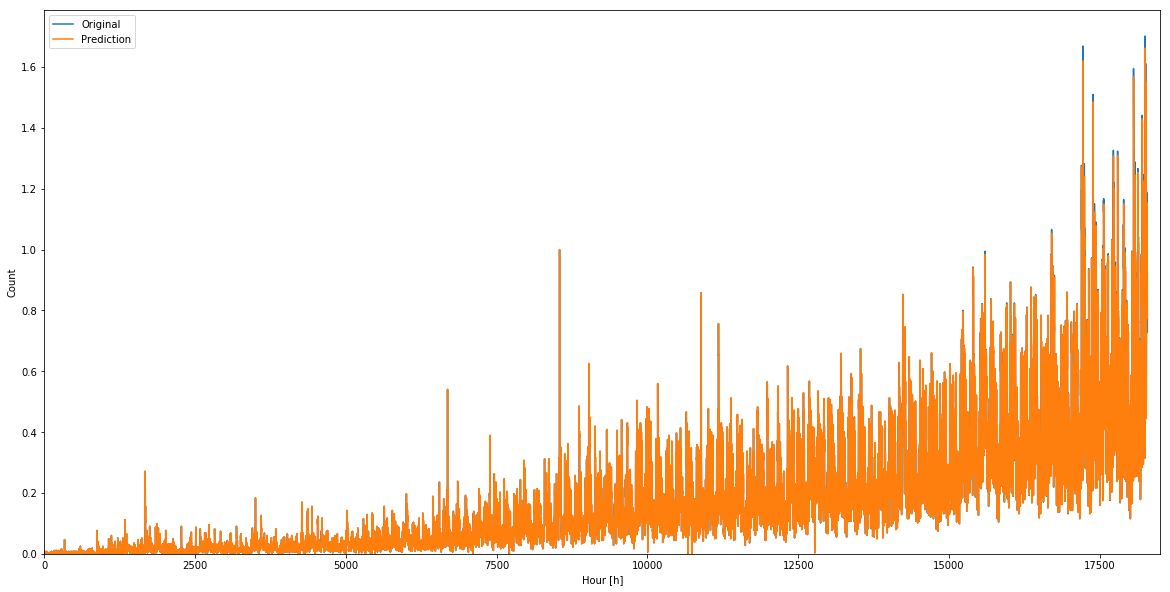

In [22]:
plt.figure( figsize =  ( 20, 10 ) )
plt.plot( data.hour, data.Count, label = "Original" )
plt.plot( data.hour[inputSize:], predAll, label = "Prediction" )
plt.xlabel("Hour [h]")
plt.ylabel("Count")
plt.legend( loc = "best" )
plt.xlim(xmin = 0, xmax = 18500 )
plt.ylim( ymin = 0 )
plt.show()

### Original vs prediction over just the testing region

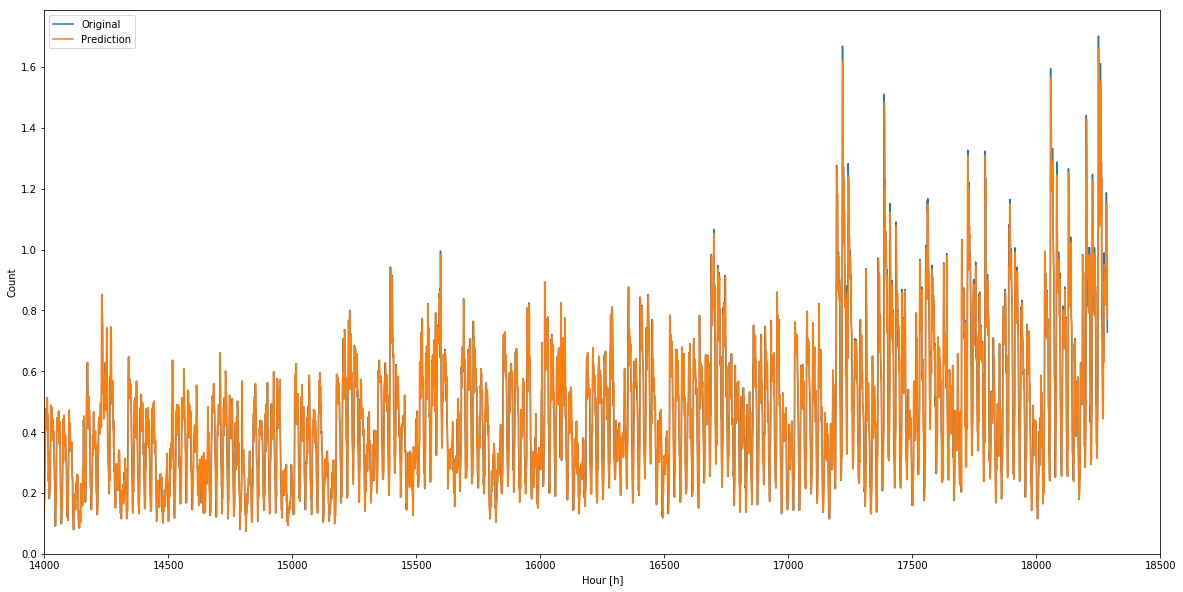

In [23]:
plt.figure( figsize =  ( 20, 10 ) )
plt.plot( data.hour, data.Count, label = "Original" )
plt.plot( data.hour[inputSize:], predAll, label = "Prediction" )
plt.xlabel("Hour [h]")
plt.ylabel("Count")
plt.legend( loc = "best" )
plt.xlim(xmin = 14000, xmax = 18500 )
plt.ylim( ymin = 0 )
plt.show()

### Loss on the test set

In [24]:
predTest = model.predict( X_test )
predTest = predTest.flatten()

testLoss = mean_squared_error( y_test, predTest )

print( f"MSE on the test set is: {testLoss : 2.2e}")

MSE on the test set is:  4.81e-05
